In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error as mae
#from xgboost import XGBRegressor
#from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#from keras.models import Sequential
#from keras.layers import LSTM, Dense

In [2]:
df = pd.read_csv(r"C:\Users\Lenovo\OneDrive\Desktop\demand_forecast_app\data\demad_forecasting.csv")

In [3]:
display(df.head())
display(df.tail())

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [4]:
df.shape

(913000, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [6]:
df['date'].min(), df['date'].max()

('2013-01-01', '2017-12-31')

In [36]:
df[(df['date']>='2017-01-01') & (df['date']<='2017-01-07') 
   & (df['store']==10) & (df['item']==40)][['date','sales']] 

,date,sales
730035,2017-01-01,34
730036,2017-01-02,29
730037,2017-01-03,22
730038,2017-01-04,24
730039,2017-01-05,19
730040,2017-01-06,26
730041,2017-01-07,34


In [7]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [8]:
df['date'] = pd.to_datetime(df['date'], errors='coerce', format='%Y-%m-%d')
df['date'].dtypes

dtype('<M8[ns]')

# Feature Engineering

In [9]:
df['year']= df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df.date.dt.weekday

In [10]:
df.head(3)

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3


Holidays often lead to significant changes in consumer behavior, so having an indicator for holidays can help the model capture these variations.

In [11]:
# Added colum holidays to indicate a holiday or no holiday.
from datetime import date
import holidays

def is_holiday(x):
  india_holiday = holidays.country_holidays('IN')

  if india_holiday.get(x):
    return 1
  else:
    return 0

df['holidays'] = df['date'].apply(is_holiday)
df.head()

,date,store,item,sales,year,month,day,weekday,holidays
0,2013-01-01,1,1,13,2013,1,1,1,0
1,2013-01-02,1,1,11,2013,1,2,2,0
2,2013-01-03,1,1,14,2013,1,3,3,0
3,2013-01-04,1,1,13,2013,1,4,4,0
4,2013-01-05,1,1,10,2013,1,5,5,0


Adding cyclical features (like sine and cosine transformations of the day, month, or week) is a good for demand forecasting.These transformations help capture the cyclical nature of time, such as recurring patterns throughout the month or week, improving the model's ability to learn and predict seasonal variations.

In [12]:
#Adding cyclical features sin and cosine
df['m1'] = np.sin(df['month'] * (2*np.pi / 12))
df['m2'] = np.cos(df['month'] * (2*np.pi / 12))
df.head(3)

,date,store,item,sales,year,month,day,weekday,holidays,m1,m2
0,2013-01-01,1,1,13,2013,1,1,1,0,0.5,0.866025
1,2013-01-02,1,1,11,2013,1,2,2,0,0.5,0.866025
2,2013-01-03,1,1,14,2013,1,3,3,0,0.5,0.866025


In [13]:
#Removing unuseful columns
# df.drop(columns='date', axis=1, inplace=True)
df.columns  # keeping the date column

Index(['date', 'store', 'item', 'sales', 'year', 'month', 'day', 'weekday',
       'holidays', 'm1', 'm2'],
      dtype='object')

In [14]:
df['store'].nunique(), df['item'].nunique()

(10, 50)

Add lag feature to improve LSTMs prediction. 
To add lag features, will shift sales column by a specific number of time steps (e.g., previous day, previous week). This will allow the LSTM model to learn temporal. how we can handle predictions for each store-item pair. dependencies.

In [15]:

# Create lag features for 'sales' - using the previous 3 days (lag_1, lag_2, lag_3)
def create_lag_features(df, lags=3):
    df_lagged = df.copy()
    for lag in range(1, lags + 1):
        df_lagged[f'sales_lag_{lag}'] = df_lagged.groupby(['store', 'item'])['sales'].shift(lag)
    df_lagged.dropna(inplace=True)  # Drop rows where any lag is missing
    return df_lagged

df_lagged = create_lag_features(df, lags=3)
print(df_lagged)

             date  store  item  sales  year  month  day  weekday  holidays  \
3      2013-01-04      1     1     13  2013      1    4        4         0   
4      2013-01-05      1     1     10  2013      1    5        5         0   
5      2013-01-06      1     1     12  2013      1    6        6         0   
6      2013-01-07      1     1     10  2013      1    7        0         0   
7      2013-01-08      1     1      9  2013      1    8        1         0   
...           ...    ...   ...    ...   ...    ...  ...      ...       ...   
912995 2017-12-27     10    50     63  2017     12   27        2         0   
912996 2017-12-28     10    50     59  2017     12   28        3         0   
912997 2017-12-29     10    50     74  2017     12   29        4         0   
912998 2017-12-30     10    50     62  2017     12   30        5         0   
912999 2017-12-31     10    50     82  2017     12   31        6         0   

                  m1        m2  sales_lag_1  sales_lag_2  sales

In [16]:
df_lagged['weekend'] = df_lagged['weekday'].apply(lambda x: 1 if x>=5 else 0)

# Visualization

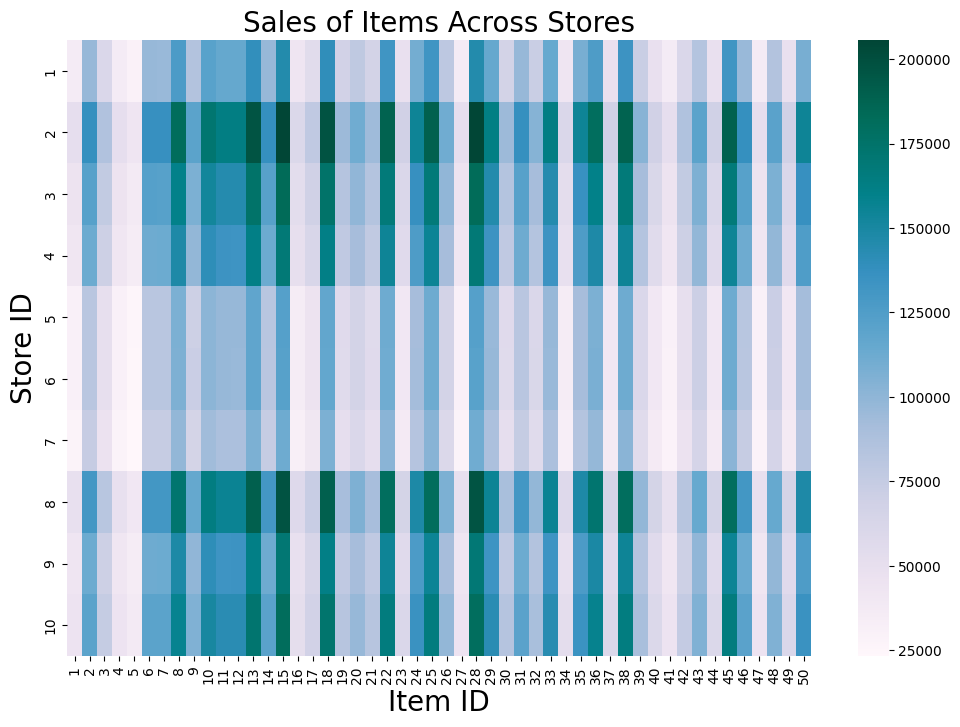

In [19]:
# visualize which store is selling which item the most
sales_matrix = df.pivot_table(index='store', columns='item', values='sales',
                              aggfunc='sum', fill_value=0)

#plot the heatmap
plt.figure(figsize=(12,8))
sns.heatmap(sales_matrix, cmap='PuBuGn')

# customize labels and title
plt.title("Sales of Items Across Stores", fontsize=20)
plt.xlabel("Item ID", fontsize=20)
plt.ylabel("Store ID", fontsize=20)
plt.show();

### Top 5 product per store

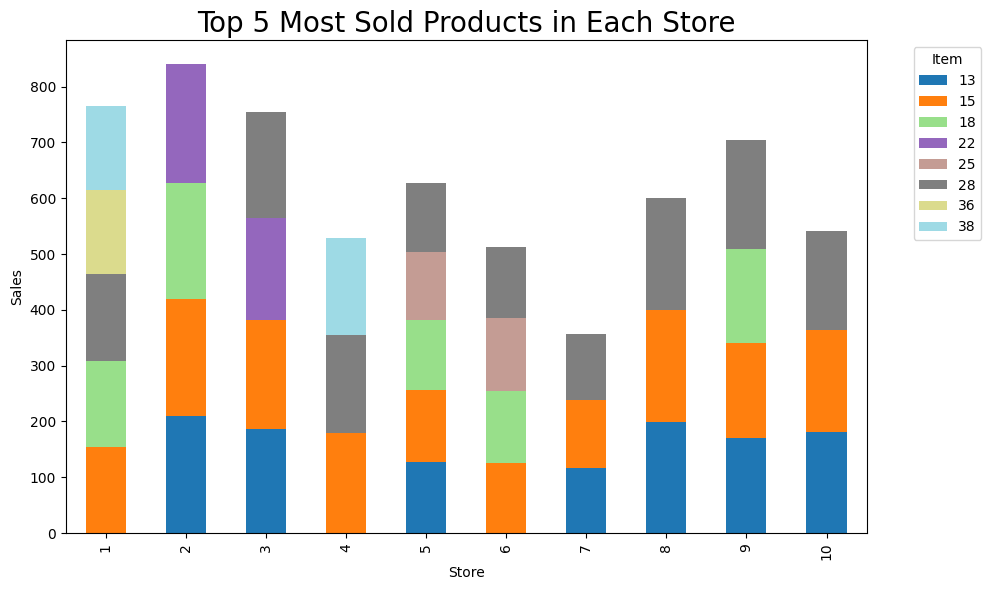

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Rank products within each store based on sales
df['rank'] = df.groupby('store')['sales'].rank(method='dense', ascending=False)
# Dense ranking ensures consistency when there are ties in sales.

# Filter for top 5 products per store
top_products = df[df['rank'] <= 5].copy()  # Filter and retain rank for inspection

# Step 2: Drop duplicate store-item combinations if necessary
# This step ensures no duplicate rows exist, though it might not always be needed
top_products = top_products.drop_duplicates(subset=['store', 'item'])

# Step 3: Pivot the data for stacked bar plot
pivot_data = top_products.pivot(index='store', columns='item', values='sales').fillna(0)

# Step 4: Plot the stacked bar plot
pivot_data.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
plt.title('Top 5 Most Sold Products in Each Store', fontsize=20)
plt.xlabel('Store')
plt.ylabel('Sales')
plt.legend(title='Item', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

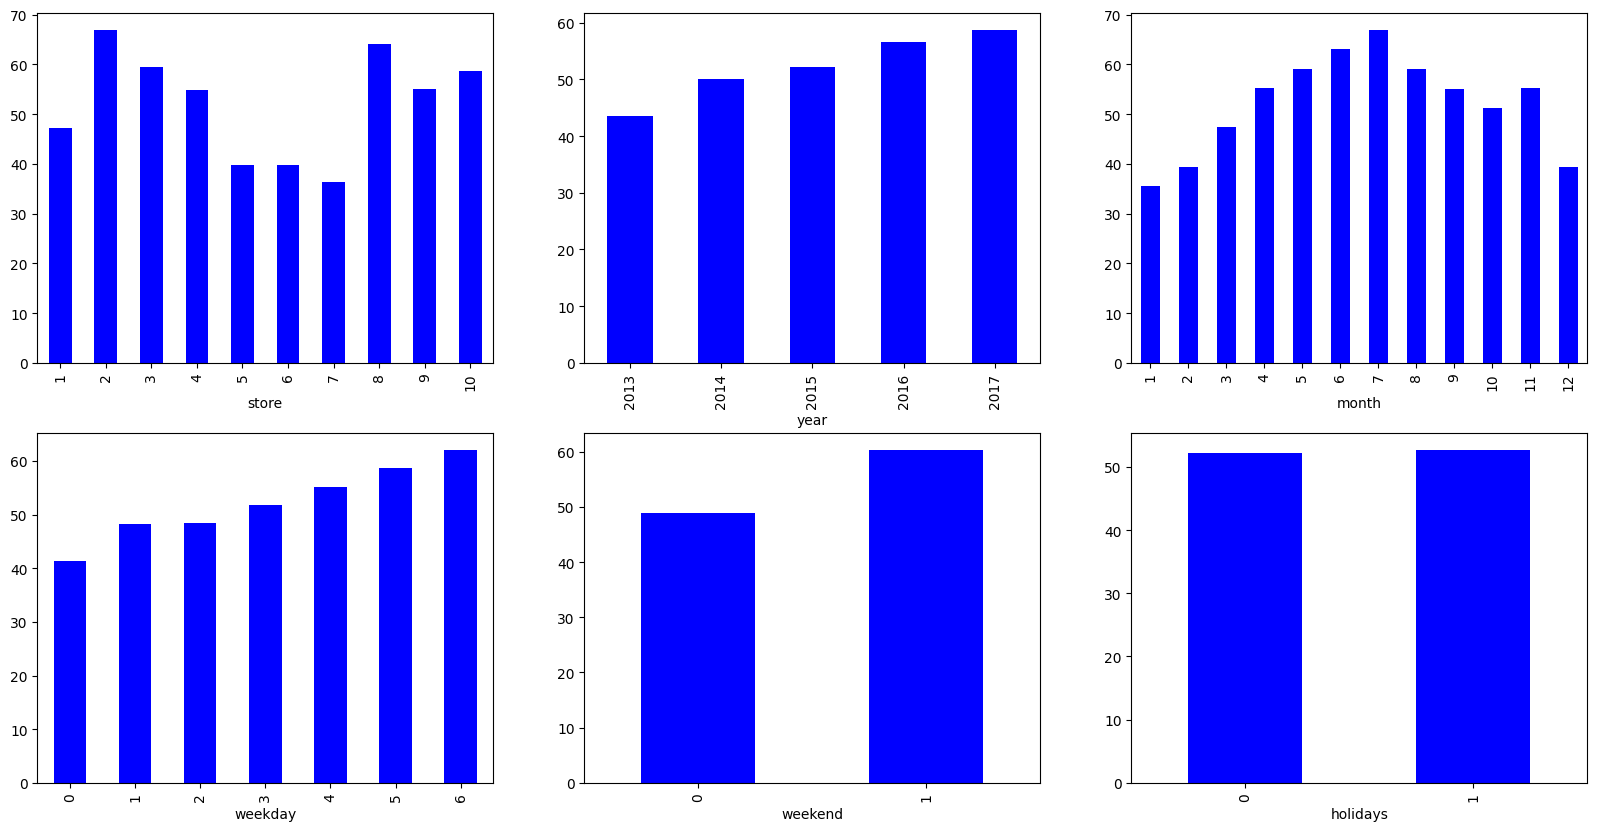

In [27]:
# show the average sales for each store, year, month, weekday, weekend, and holidays

features =['store', 'year', 'month', 'weekday', 'weekend', 'holidays']

plt.subplots(figsize=(20,10))
for i,col in enumerate(features):
  plt.subplot(2,3,i+1)
  df.groupby(col).mean()['sales'].plot.bar(color='blue')
plt.show();

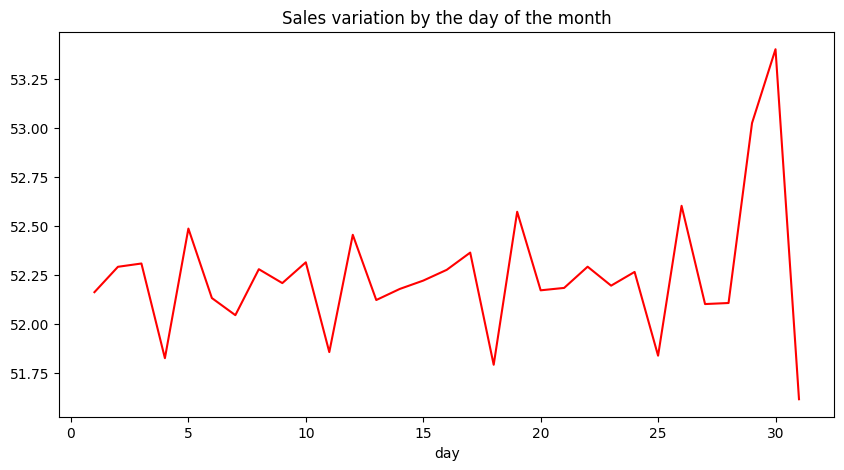

In [28]:
# Checking  sales variation by the day of the month.
plt.figure(figsize=(10,5))
df.groupby('day').mean()['sales'].plot(color='red')
plt.title('Sales variation by the day of the month')
plt.show();

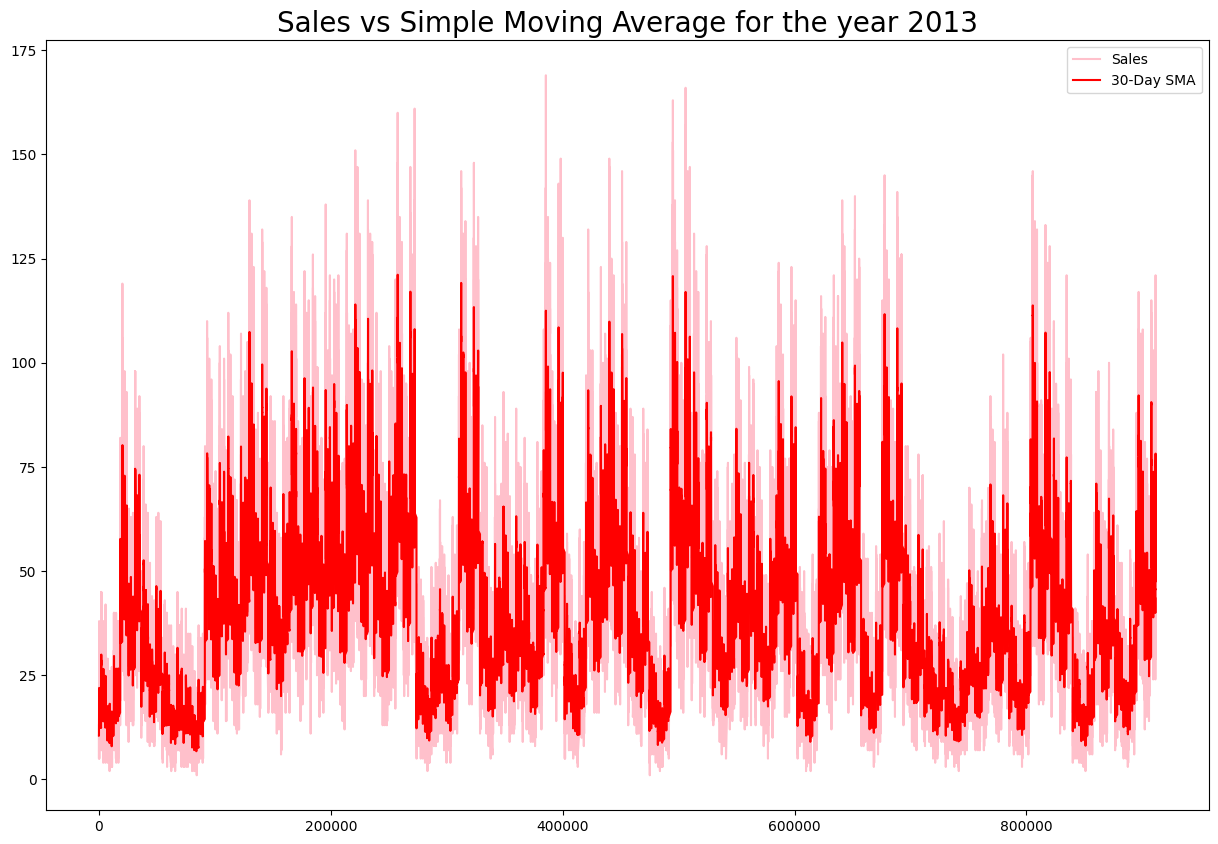

In [29]:
plt.figure(figsize=(15,10))
# Plotting original sales data and the 30-day Simple Moving Average
# Calculating Simple Moving Average for the year 2013
# for a window period of 30 days
window_size = 30
data = df[df['year'] == 2013]
windows = data['sales'].rolling(window_size)
sma = windows.mean()
sma = sma[window_size - 1:]

data['sales'].plot(label='Sales',color='pink')
sma.plot(label='30-Day SMA', color='red')
plt.legend()
plt.title('Sales vs Simple Moving Average for the year 2013', fontsize=20)
plt.show();


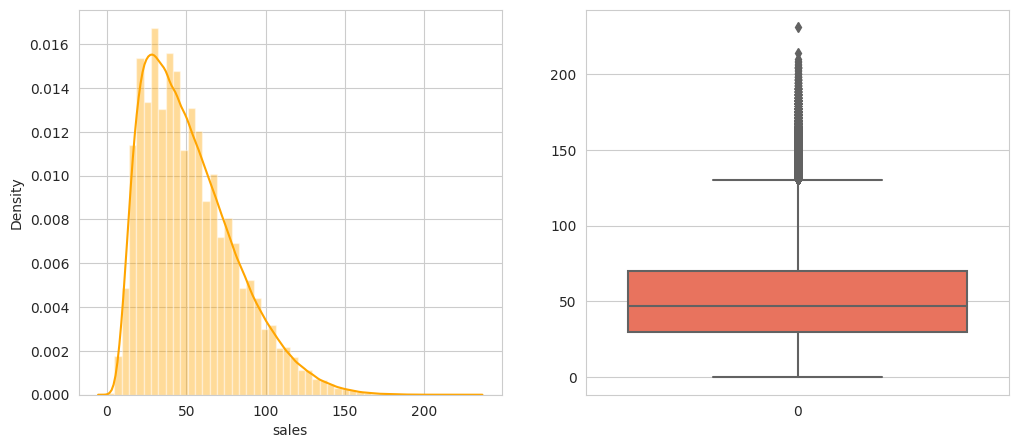

In [30]:
sns.set_style('whitegrid')
plt.subplots(figsize=(12,5))
plt.subplot(1,2,1)
sns.distplot(df['sales'], color='orange')

plt.subplot(1,2,2)
sns.boxplot(df['sales'], color='#FF6347')

plt.show();

Though they seem to be outliers but in sales some commodities can actually have high selling price.

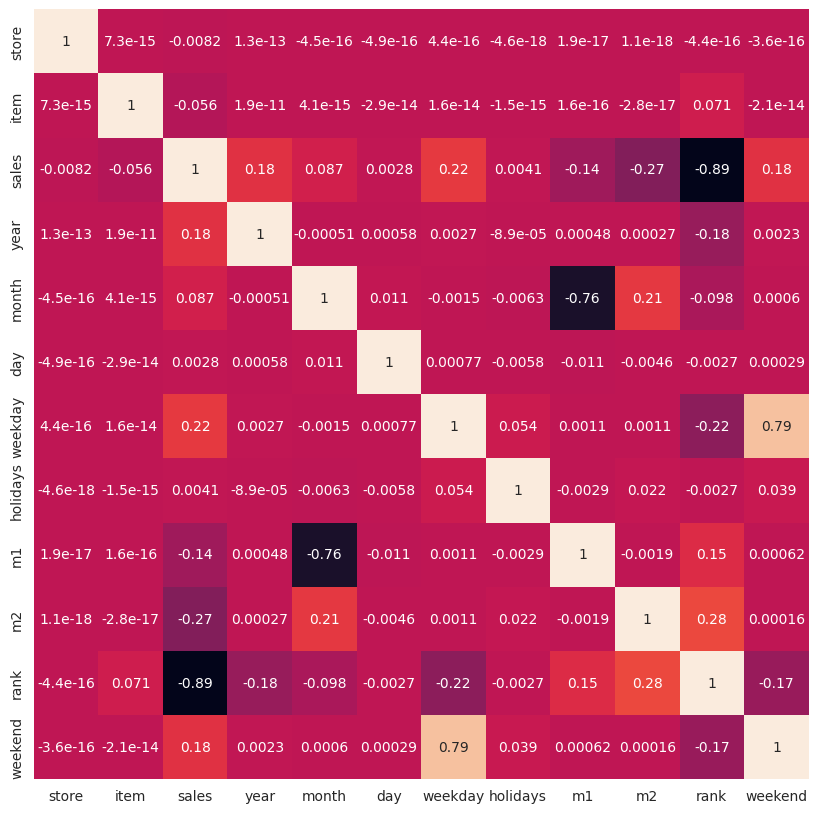

In [31]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, cbar=False)
plt.show();

# RandomForestRegressor

In [17]:
df_lagged.columns

Index(['date', 'store', 'item', 'sales', 'year', 'month', 'day', 'weekday',
       'holidays', 'm1', 'm2', 'sales_lag_1', 'sales_lag_2', 'sales_lag_3',
       'weekend'],
      dtype='object')

In [18]:
feature = df_lagged.drop(['sales'], axis=1)
tar = df_lagged['sales']

X_trains,X_tests,y_trains,y_tests = train_test_split(feature,tar,test_size=0.2, shuffle=False)
X_trains.shape, X_tests.shape

((729200, 14), (182300, 14))

In [23]:
X_trains.drop(columns='date', inplace=True)
X_tests.drop(columns='date', inplace=True) 

In [24]:
X_trains.columns

Index(['store', 'item', 'year', 'month', 'day', 'weekday', 'holidays', 'm1',
       'm2', 'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'weekend'],
      dtype='object')

In [ ]:
# from sklearn.preprocessing import StandardScaler
# # Normalizing the features for stable and fast training.
# scaler = StandardScaler()

# X_trains = scaler.fit_transform(X_trains)
# X_tests = scaler.transform(X_tests)

In [19]:
from sklearn.model_selection import RandomizedSearchCV

In [25]:
params = {
    'n_estimators' :[100,200,300],
    'max_depth' : [2,5,7,10,15],
    'min_samples_split' :[2,4,5,7,10,50],
    'min_samples_leaf' : [1,3,5,7,10,50],
    'max_features' :['sqrt','log2',1,5,10,15,20,70],
}

rf = RandomForestRegressor(random_state=67)

random_search = RandomizedSearchCV(rf, cv=2,param_distributions=params,
                                   scoring='neg_mean_absolute_error',n_iter=10,
                                   verbose=1, n_jobs=-1)

In [26]:
random_search.fit(X_trains,y_trains)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(random_state=67),
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 5, 7, 10, 15],
                                        'max_features': ['sqrt', 'log2', 1, 5,
                                                         10, 15, 20, 70],
                                        'min_samples_leaf': [1, 3, 5, 7, 10,
                                                             50],
                                        'min_samples_split': [2, 4, 5, 7, 10,
                                                              50],
                                        'n_estimators': [100, 200, 300]},
                   scoring='neg_mean_absolute_error', verbose=1)

In [27]:
random_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 4,
 'min_samples_leaf': 5,
 'max_features': 5,
 'max_depth': 15}

In [28]:
train_pred = random_search.predict(X_trains)
print('Training Error : ', mae(y_trains,train_pred))

Training Error :  6.1174404904576365


In [29]:
val_pred = random_search.predict(X_tests)
print('Validation error : ', mae(y_tests, val_pred))


Validation error :  6.0111646619471095


In [30]:
val_pred

array([14.70781112, 14.98535021, 14.31487289, ..., 59.92730256,
       72.65296617, 73.77175932], shape=(182300,))

In [31]:
# Save the entire RandomizedSearchCV object
import joblib
joblib.dump(random_search, r"C:\Users\Lenovo\OneDrive\Desktop\demand_forecast_app\model\rf_model.pkl")

# This saves the best-tuned RandomForest model and all its hyperparameters.

['C:\\Users\\Lenovo\\OneDrive\\Desktop\\demand_forecast_app\\model\\rf_model.pkl']

In [32]:
df_lagged.isna().sum()

date           0
store          0
item           0
sales          0
year           0
month          0
day            0
weekday        0
holidays       0
m1             0
m2             0
sales_lag_1    0
sales_lag_2    0
sales_lag_3    0
weekend        0
dtype: int64

# Preparing data for LSTM

In [47]:
# Features you want to use (add lagged sales columns)
features = ['store', 'item', 'month', 'day', 'weekday', 'holidays', 'm1', 'm2', 'weekend', 'sales_lag_1', 'sales_lag_2', 'sales_lag_3']
target = ['sales']

In [48]:
df_lag = df_lagged.copy()
df_lag.columns

Index(['store', 'item', 'sales', 'year', 'month', 'day', 'weekday', 'holidays',
       'm1', 'm2', 'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'weekend'],
      dtype='object')

In [49]:
from sklearn.preprocessing import MinMaxScaler
# Normalize the features
scaler = MinMaxScaler()
df_lag[features] = scaler.fit_transform(df_lag[features])

In [50]:
# Prepare X (features) and y (target)
X = df_lag[features].values
y = df_lag[target].values

In [51]:
df_lag.columns

Index(['store', 'item', 'sales', 'year', 'month', 'day', 'weekday', 'holidays',
       'm1', 'm2', 'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'weekend'],
      dtype='object')

Create Sequences for LSTM Input. 30 day seq length.<br>• time_step	30 days: For capturing monthly seasonality and trends. By using a 30-day window, the model will have a chance to learn patterns that are representative of a "typical" month

In [52]:
import numpy as np

def create_sequences(df, sequence_length=30):
    X = []
    y = []

    # Loop over the data to create sequences
    for i in range(sequence_length, len(df)):
        # Input features: all columns except the 'sales' column (target)
        #  'sales' is the 3rd column in the data
        X.append(df[i-sequence_length:i, 2:])  # This excludes the 'sales' column (column index 2)

        # Target: the 'sales' column (index 2)
        y.append(df[i, 2])  # The target is the 'sales' value for the current row

    return np.array(X), np.array(y)

# Assuming df_lagged is your dataframe with lag features (X and y)
sequence_length = 30  # Look back for 30 days
X, y = create_sequences(df_lag.values, sequence_length)

# Reshape X to the shape expected by LSTM (samples, time_steps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))  # (samples, time_steps, features)


In [53]:
# Split the data into training and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)  # 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [54]:
X_train.shape

(729176, 30, 12)

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

# Define the LSTM model architecture with Dropout and BatchNormalization
model = Sequential()

# Adding LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))  # 30 time steps
model.add(Dropout(0.2))  # Dropout layer with 20% dropout rate
model.add(BatchNormalization())  # BatchNormalization layer

# Optionally, you can add another LSTM layer
model.add(LSTM(units=50, return_sequences=False))  # Second LSTM layer
model.add(Dropout(0.2))  # Dropout for the second LSTM layer
model.add(BatchNormalization())  # BatchNormalization for the second LSTM layer

# Output layer for sales prediction
model.add(Dense(units=1))  # Single output for predicting sales

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Summary of the model
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 50)              │          12,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 50)              │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 50)                  │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,251 (129.89 KB)

 Trainable params: 33,051 (129.11 KB)

 Non-trainable params: 200 (800.00 B)

In [56]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',          # Filepath to save the model
    monitor='val_mae',                    # Metric to monitor (val_mae for regression)
    save_best_only=True,                  # Save only the model with the best val_mae
    mode='min',                           # Mode for monitoring (minimize val_mae)
    verbose=1                             # Display logs when the model is saved
)


In [57]:
# Train the model with the callback
history = model.fit(
    X_train,y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[checkpoint_callback]   # Add the ModelCheckpoint callback
)

# The best model is saved as 'best_model.keras'


Epoch 1/10
11389/11394 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 634.3732 - mae: 16.9800
Epoch 1: val_mae improved from inf to 19.37951, saving model to best_model.keras
11394/11394 ━━━━━━━━━━━━━━━━━━━━ 101s 8ms/step - loss: 634.1642 - mae: 16.9765 - val_loss: 433.6783 - val_mae: 19.3795
Epoch 2/10
11394/11394 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 97.6764 - mae: 7.5692
Epoch 2: val_mae did not improve from 19.37951
11394/11394 ━━━━━━━━━━━━━━━━━━━━ 94s 8ms/step - loss: 97.6763 - mae: 7.5692 - val_loss: 4711.2617 - val_mae: 67.4399
Epoch 3/10
11393/11394 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 92.2485 - mae: 7.3815
Epoch 3: val_mae did not improve from 19.37951
11394/11394 ━━━━━━━━━━━━━━━━━━━━ 94s 8ms/step - loss: 92.2485 - mae: 7.3815 - val_loss: 801.4427 - val_mae: 25.6392
Epoch 4/10
11390/11394 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 90.9049 - mae: 7.3292
Epoch 4: val_mae did not improve from 19.37951
11394/11394 ━━━━━━━━━━━━━━━━━━━━ 94s 8ms/step - loss: 90.9049 - mae: 7.3292 - va

In [ ]:
Retrieving the Best Epoch:

In [58]:
best_epoch = history.history['val_mae'].index(min(history.history['val_mae']))+1
best_val_mae = min(history.history['val_mae'])
print(f"Best Epoch: {best_epoch}, Best Validation: {best_val_mae}")

Best Epoch: 1, Best Validation: 19.379505157470703


Steps to Load the Best Model and Predict:

In [59]:
from tensorflow.keras.models import load_model
# load the best model
best_model = load_model('best_model.keras')


In [60]:
predictions = best_model.predict(X_test)
predictions

5697/5697 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


array([[35.696484],
       [38.39101 ],
       [41.36783 ],
       ...,
       [82.205666],
       [88.38198 ],
       [94.33017 ]], dtype=float32)

In [61]:
test_loss, test_mae = model.evaluate(X_test, y_test, batch_size=32)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

5697/5697 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 798.2878 - mae: 24.7711
Test Loss: 734.7938842773438
Test MAE: 22.931711196899414


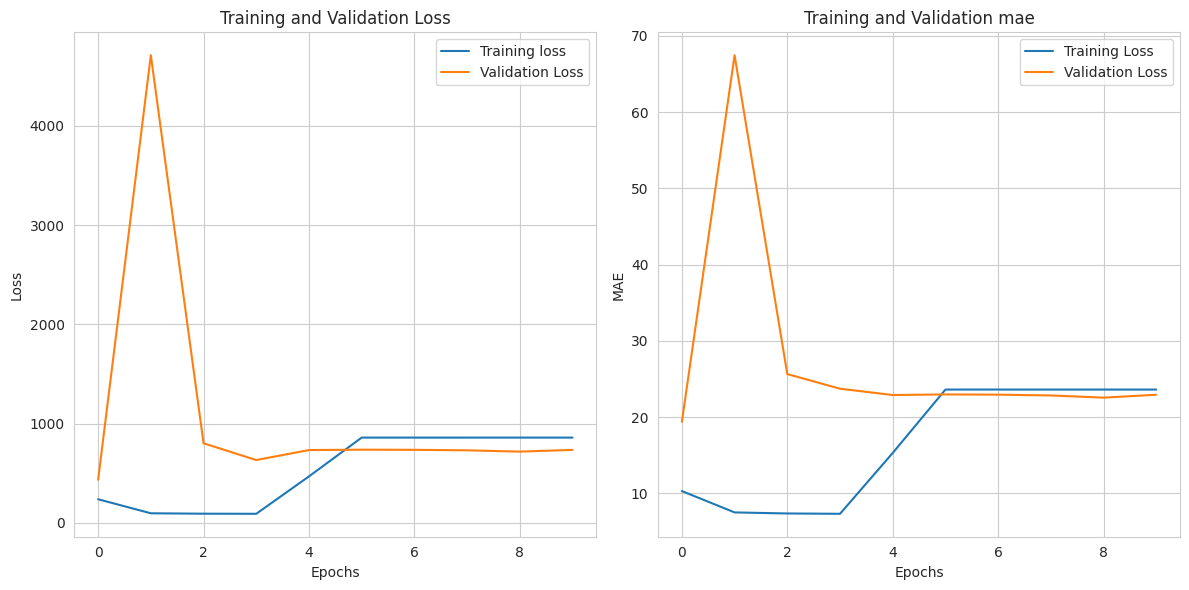

In [62]:
import matplotlib.pyplot as plt

# Assuming 'history' contains the training logs
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training Loss')
plt.plot(history.history['val_mae'], label='Validation Loss')
plt.title('Training and Validation mae')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


**RandomForestRegressor Outperformed the LSTM for this dataset**